In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib

In [2]:
import pandas as pd

In [3]:
torch.cuda.is_available()

True

In [4]:
from isaac.utils import plot_confusion_matrix
from isaac.dataset import read_dataset, prepare_dataset, normalise
from isaac.models import ComplexRNNModel
from isaac.constants import *

In [5]:
TR_COLS = ALT_BASIC_TRAINING_COLS

In [6]:
INPUT_DIM = len(TR_COLS)    # input dimension
HIDDEN_DIM = 25  # hidden layer dimension
N_LAYERS = 4     # number of hidden layers
OUTPUT_DIM = 3   # output dimension
DROPOUT = 0.5

network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM)

NORMALISE_DATA = True
STEP_SIZE = 1
SEQ_END = 2700

In [7]:
def prepare_dataset(datasets, class_columns, multiclass=False, batch_size=640, normalise_data=False, scaler=None,
                    transforms=(), sliding_window_size=1, training_columns=BASIC_TRAINING_COLS,
                    categorical_columns=(), normalisation_cols=()):    
    if len(normalisation_cols) == 0:
        normalisation_cols = training_columns

    training_columns = list(training_columns)
    columns_to_normalise_bool_index = np.array([(col not in categorical_columns) and 
                                                (col in normalisation_cols) 
                                                for col in training_columns])
    class_columns = list(class_columns)

    loaders = []

    for dataset in datasets:
        X = []
        Y = []

        for trial in tqdm(dataset):
            training_cols = trial[training_columns]
            
            for t in transforms:
                t(training_cols)

            X.append(np.array(training_cols).astype(np.float32))

            if multiclass:
                y = []
                for class_i_columns in class_columns:
                    y.append(np.argmax(np.array(trial[class_i_columns].iloc[0])))
                Y.append(y)
            else:
                Y.append(np.argmax(np.array(trial[class_columns].iloc[0])))

        X = np.array(X)
        if sliding_window_size > 1:
            X = get_sliding_windows_for_all_trials(X, sliding_window_size)
            X = X.reshape(X.shape[0], X.shape[1], X.shape[2] * X.shape[3])
        Y = np.array(Y)

        if normalise_data:
            if scaler is None:
                scaler = StandardScaler()
                X = normalise(X, scaler, fit_scaler=True, columns_to_normalise_bool_index=columns_to_normalise_bool_index)
            else:
                X = normalise(X, scaler, fit_scaler=False, columns_to_normalise_bool_index=columns_to_normalise_bool_index)

        X = torch.from_numpy(X).cuda()
        Y = torch.from_numpy(Y).type(torch.LongTensor).cuda()

        tensor_dataset = torch.utils.data.TensorDataset(X, Y)
        data_loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False)
        loaders.append(data_loader)

    if len(datasets) == 1:
        return loaders[0], scaler

    return loaders, scaler

In [8]:
def find_padding_start(trial, seq_end):
    return np.amax((trial.cpu().numpy() == np.zeros((trial.shape[1]))).all(axis=1).nonzero()[0], initial=seq_end)

In [9]:
def evaluate(model, val_loader, return_predicted=False, seq_start=None, seq_end=None, step_size=None):
    predicted = []
    correct = 0
    total = 0
    for x_val, y_val in val_loader:
        this_trial_seq_end = find_padding_start(x_val[0], seq_end)
        x_val = Variable(x_val[:, seq_start:this_trial_seq_end:step_size, :])
        
        y_hat = model(x_val)

        current_prediction = torch.max(y_hat.data, 1)[1]
        # total += y_val.size(0)
        total += 1
        correct += (current_prediction == y_val).sum().cpu().numpy()
        
        predicted.extend(current_prediction)

        
    accuracy = 100 * correct / float(total)
    if return_predicted:
        return accuracy, predicted
    return accuracy

def evaluate_saved_model(model_path, network_dims, test_dataset_path, training_columns, class_columns, seq_start=None, 
                         seq_end=None, step_size=None, scaler_path=None, trials=None, arch=ComplexRNNModel, multiclass=False,
                         categorical_columns=(), normalisation_cols=()):
    
    class_columns = list(class_columns)
    training_columns = list(training_columns)
    
    if scaler_path:
        scaler = joblib.load(scaler_path)
        normalise_data=True
    else:
        scaler = None
        normalise_data=False
        
    model = arch(*network_dims)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model = model.cuda()
    
    if trials is None:
        trials = read_dataset(test_dataset_path)
    
    trials = [trial[trial.C_none] for trial in trials]
    trials = [pd.concat((trial, pd.DataFrame(np.zeros((seq_end - len(trial), trial.shape[1])), columns=trial.columns))) for trial in trials]
    
    test_loader, _ = prepare_dataset([trials], class_columns, normalise_data=normalise_data, 
                                     scaler=scaler, training_columns=training_columns, multiclass=multiclass,
                                     categorical_columns=categorical_columns, normalisation_cols=normalisation_cols,
                                     batch_size=1)
    
    accuracy, predicted = evaluate(model, test_loader, return_predicted=True, seq_start=seq_start, step_size=step_size, seq_end=seq_end)
    
    print("Model's accuracy on test set:", accuracy)
    
    predicted = [pred.cpu() for pred in predicted]
    Y_test = np.concatenate([y.cpu().numpy() for x, y in test_loader])
    
    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=False)
    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=True)

# MASS TESTING

100%|██████████| 143/143 [00:00<00:00, 803.04it/s]


Model's accuracy on test set: 51.74825174825175
data/yoked_trials_exp1.h5


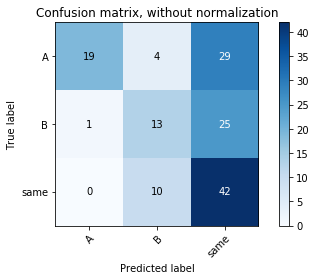

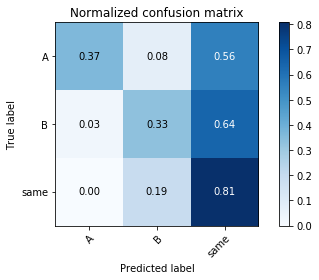

100%|██████████| 399/399 [00:00<00:00, 718.48it/s]


Model's accuracy on test set: 44.611528822055135
data/mass_trials_exp2.h5


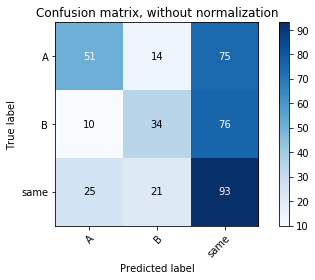

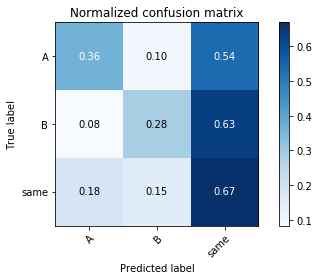

100%|██████████| 399/399 [00:00<00:00, 689.15it/s]


Model's accuracy on test set: 44.86215538847118
data/force_trials_exp2.h5


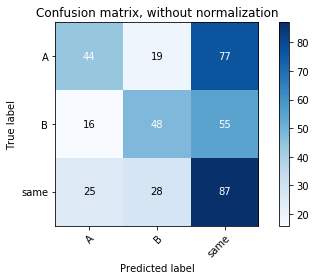

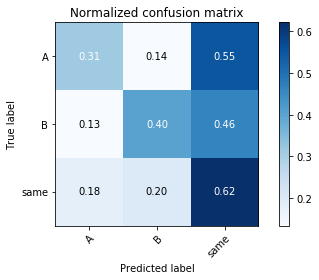

In [10]:
model_path = "models/passive_mass_model.pt"
scaler_path = "scalers/passive_mass_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
class_columns = MASS_CLASS_COLS

passive_datasets = ["data/val_passive_trials.h5", "data/test_passive_trials.h5", "data/passive_trials_exp1.h5"]
for test_dataset_path in ["data/yoked_trials_exp1.h5", "data/mass_trials_exp2.h5", 
                          "data/force_trials_exp2.h5"]:
    evaluate_saved_model(model_path, network_dims, test_dataset_path, TR_COLS,
                         class_columns, step_size=STEP_SIZE, seq_end=SEQ_END+1, scaler_path=scaler_path)
    print(test_dataset_path)
    plt.show()

# FORCE TESTING

100%|██████████| 1000/1000 [00:01<00:00, 798.37it/s]


Model's accuracy on test set: 67.1
data/val_passive_trials.h5


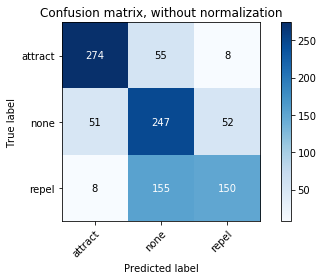

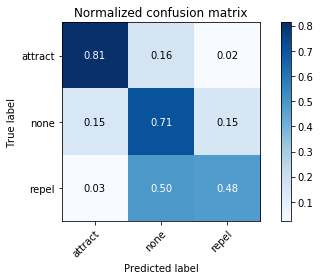

100%|██████████| 1000/1000 [00:01<00:00, 797.14it/s]


Model's accuracy on test set: 62.2
data/test_passive_trials.h5


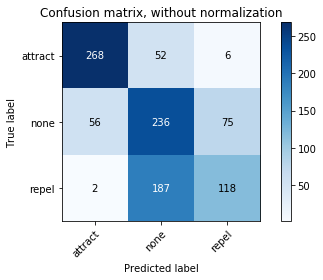

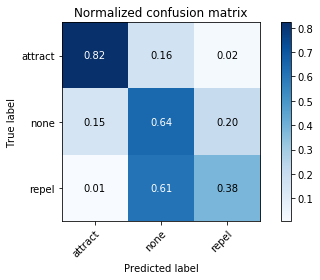

100%|██████████| 196/196 [00:00<00:00, 770.63it/s]


Model's accuracy on test set: 65.3061224489796
data/passive_trials_exp1.h5


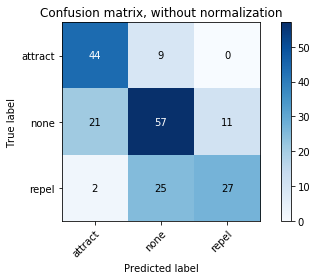

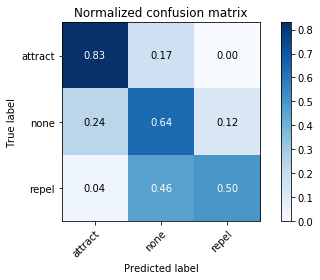

100%|██████████| 143/143 [00:00<00:00, 786.24it/s]


Model's accuracy on test set: 53.14685314685315
data/yoked_trials_exp1.h5


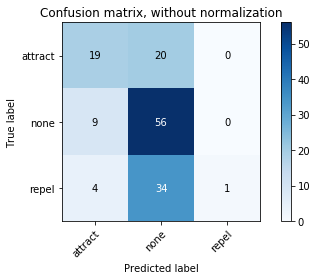

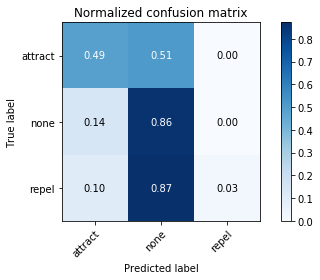

100%|██████████| 399/399 [00:00<00:00, 747.68it/s]


Model's accuracy on test set: 38.847117794486216
data/mass_trials_exp2.h5


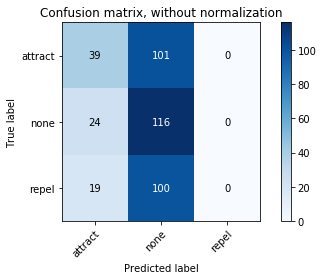

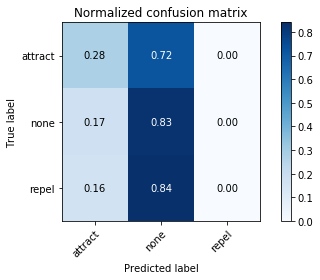

100%|██████████| 399/399 [00:00<00:00, 763.38it/s]


Model's accuracy on test set: 38.59649122807018
data/force_trials_exp2.h5


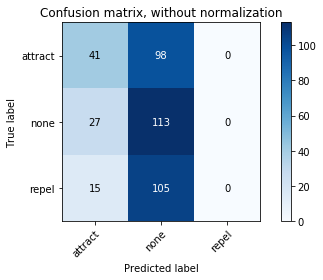

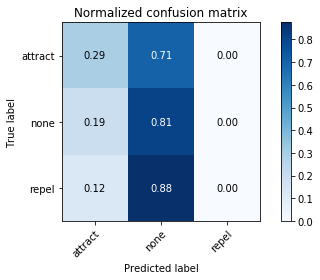

In [12]:
model_path = "models/passive_force_model.pt"
scaler_path = "scalers/passive_force_scaler.sk"
network_dims = (INPUT_DIM, HIDDEN_DIM, N_LAYERS, OUTPUT_DIM, DROPOUT)
class_columns = FORCE_CLASS_COLS

for test_dataset_path in ["data/val_passive_trials.h5", "data/test_passive_trials.h5", 
                          "data/passive_trials_exp1.h5", 
                          "data/yoked_trials_exp1.h5", "data/mass_trials_exp2.h5", 
                          "data/force_trials_exp2.h5"]:

    evaluate_saved_model(model_path, network_dims, test_dataset_path, TR_COLS,
                         class_columns, step_size=STEP_SIZE, seq_end=SEQ_END+1, scaler_path=scaler_path)
    print(test_dataset_path)
    plt.show()